# 2.3 Pomiar jakości podziału
Skąd możemy mieć gwarancję, że wybrano najlepszą cechę i najlepszą wartość dla podziału? Oczywiście mamy sposoby, żeby zmierzyć nasz wybór i porównać go z innymi możliwymi do dokonania na tym etapie.

Przejdziemy przez schemat tworzenia drzewa w bardzo prostym przypadku. Do tego celu stworzymy zbiór danych opisujący skuteczność pewnego leku na chorobę X, w zależności od użytej dawki. Będziemy więc rozpatrywać przypadek dwuwymiarowy, który dodatkowo zostanie wygenerowany losowo.

In [1]:
import numpy as np
import pandas as pd

In [2]:
np.random.seed(135)

patients_df = pd.DataFrame({
    "dosage_mg": 10 * np.random.random(size=25)
})
patients_df.sample(5)

,dosage_mg
10,3.733196
14,0.330930
22,3.186789
13,1.740597
2,1.953982


Nasz zbiór jest sztucznie wygenerowany, co oznacza, że to my ustalamy zasady. W związku z tym ustalmy, że lek jest skuteczny powyżej pewnej dawki, ale jeśli przesadzimy, to znowu przestaje być skuteczny.

In [3]:
recovered = (3.7 < patients_df["dosage_mg"]) & (patients_df["dosage_mg"] < 6.54)
recovered

0     False
1     False
2     False
3     False
4     False
5     False
6      True
7     False
8     False
9     False
10     True
11    False
12     True
13    False
14    False
15     True
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24     True
Name: dosage_mg, dtype: bool

<Axes: xlabel='dosage_mg', ylabel='recovered'>

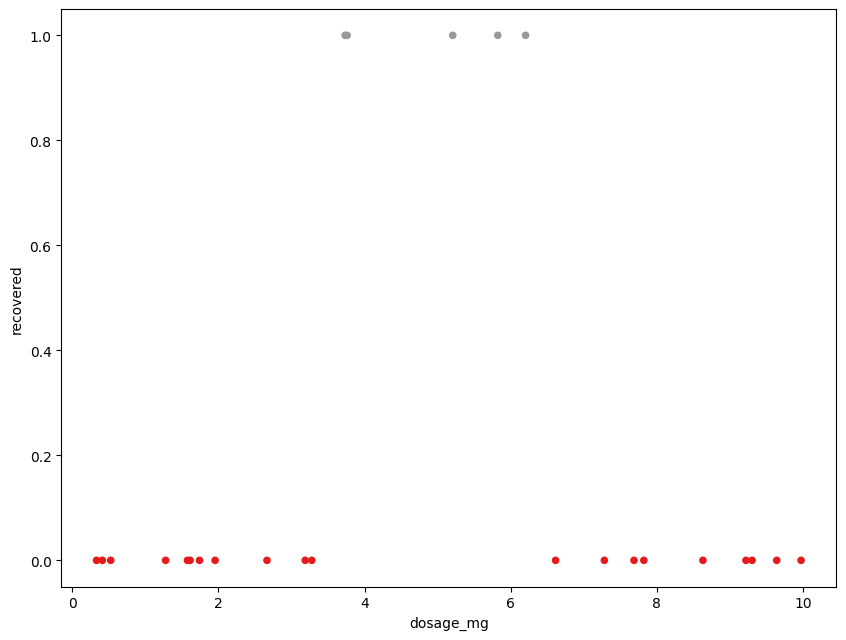

In [4]:
patients_df["recovered"] = recovered.astype(int)
patients_df.plot.scatter(x="dosage_mg", y="recovered", c="recovered", cmap="Set1", figsize=(10, 7.5), colorbar=False)

## Szukanie najlepszych warunków dla drzewa
W trakcie procesu uczenia drzewa decyzyjnego dla klasyfikacji, kluczowym jest odnalezienie takich warunków, które jak najlepiej odseparują nam obserwacje należące do różnych grup. W naszym przypadku znamy prawidłowe zależności w danych, ale typowo potrzebujemy je odnaleźć. Dość istotne są następujące fakty:
* Każdy warunek w drzewie decyzyjnym, dzieli aktualny zbiór obserwacji na dwie części, niekoniecznie równoliczne.
* Jednorazowo rozpatrujemy tylko jeden wymiar danych
* Każdy podział tworzy nam dwa osobne poddrzewa, niezależne od poprzednich działań

W związku z tym, typowy proces będzie po pierwsze wymagał wyboru cechym na podstawie której chcemy dokonać podziału, a następnie wyboru granicznej wartości, która znajdzie się w warunku. W naszym przypadku jest tylko jedna cecha, więc z automatu jest ona najlepszym kryterium podziału.

Gdy już dokonamy wyboru cechy, to właściwie rozpatrujemy przypadek jednowymiarowy. W przypadku danych numerycznych będziemy po prostu sortować wszystkie wartości w danej kolumnie i po kolei rozpatrywać punkty pośrednie pomiędzy parami punktów (tak, aby żaden punkt danych nie leżał na granicy decyzji, dzięki czemu możemy wykorzystać tylko ostrą nierówność). W jaki jednak sposób określić, który punkt podziału jest najlepszy?

### Pomiar jakości podziału
Na każdym poziomie drzewa mamy pewien podzbiór oryginalnych obserwacji. Możemy opisać jak jednorodny jest to podzbiór, obliczając proporcję elementów należących do klasy k w następujący sposób:

pk = (suma od i=0 do N-1 I(yi = k)) / N

Innymi słowy, jest to procent obserwacji należących do danej klasy. W przypadku drzewa możemy dodatkowo ponumerować wszystkie rozgałęzienia (węzły) i obliczyć tę proporcję w następujący sposób:

pmk = (suma xi należy do Rm z I(yi = k)) / Nm

Gdzie m jest indeksem danego węzła, Nm liczbą obserwacji w tym poddrzewie, a Rm to zbiór tych obserwacji.

Tworząc drzewo, przeglądamy kolejne możliwe wartości podziału w danym wymiarze, a także niejawnie tworzymy lewe i prawe poddrzewa sprawdzając przy tym wartość tzw. impurity measure, czyli funkcji nieczystości, starając się zminimalizować jej wartość. O tych funkcjach będzie trochę później - na razie zobaczmy jak będzie zmieniać się proporcja w zależności od wybranego punktu podziału, dla naszego przykładu

### Jakość podziału w przypadku różnych dawek leku
Nasz zbiór składa się z 25 punktów danych, a każdy z nich opisuje inną dawkę leku. Pomiędzy tymi punktami istnieje więc 24 punkty pośrednie, które będziemy rozpatrywać jako kolejne granice. Prześledzimy jak kształtują się wartości proporcji dla poszczególnych podziałów. Zacznijmy jednak od obliczenia proporcji całego zbioru.

In [7]:
patients_df

,dosage_mg,recovered
0,6.613289,0
1,3.276947,0
2,1.953982,0
3,8.629823,0
4,7.821323,0
5,1.575420,0
6,5.206057,1
7,9.639556,0
8,0.525559,0
9,9.302636,0


In [5]:
def p(y, class_names):
    prob = []
    for class_name in class_names:
        try:
            prob.append(y[y == class_name].shape[0] / y.shape[0])
        except ZeroDivisionError:
            prob.append(0.0)
    return np.array(prob)

In [6]:
p(patients_df["recovered"], [0, 1])

array([0.8, 0.2])

Wynik się oczywiście zgadza, ponieważ mamy 20 na 25 próbek z fałszem (zerami) i 5 z 25 z prawdą (jedynkami), czyli 4/5 + 1/5 == 0.8 i 0.2

In [8]:
sorted_patients_df = patients_df.sort_values("dosage_mg", ascending=True)
sorted_patients_df.head()

,dosage_mg,recovered
14,0.330930,0
18,0.410895,0
8,0.525559,0
11,1.276631,0
5,1.575420,0


In [9]:
thresholds = sorted_patients_df["dosage_mg"].rolling(2).mean()
thresholds

14         NaN
18    0.370912
8     0.468227
11    0.901095
5     1.426026
21    1.593392
13    1.675980
2     1.847289
20    2.308727
22    2.925131
1     3.231868
10    3.505071
12    3.747177
6     4.483607
24    5.514322
15    6.012739
0     6.408091
17    6.947133
19    7.483763
4     7.753936
3     8.225573
23    8.924132
9     9.260539
7     9.471096
16    9.806038
Name: dosage_mg, dtype: float64

In [10]:
def filter_patients(threshold):
    return patients_df[patients_df["dosage_mg"] <= threshold]["recovered"]

proportions_df = pd.DataFrame({
    "threshold": thresholds.dropna()
})
proportions_df["positive_proportion"] = thresholds.map(lambda t: p(filter_patients(t), [1]) [0])
proportions_df["negative_proportion"] = thresholds.map(lambda t: p(filter_patients(t), [0]) [0])

In [11]:
proportions_df

,threshold,positive_proportion,negative_proportion
18,0.370912,0.000000,1.000000
8,0.468227,0.000000,1.000000
11,0.901095,0.000000,1.000000
5,1.426026,0.000000,1.000000
21,1.593392,0.000000,1.000000
13,1.675980,0.000000,1.000000
2,1.847289,0.000000,1.000000
20,2.308727,0.000000,1.000000
22,2.925131,0.000000,1.000000
1,3.231868,0.000000,1.000000


<Axes: xlabel='threshold', ylabel='recovered'>

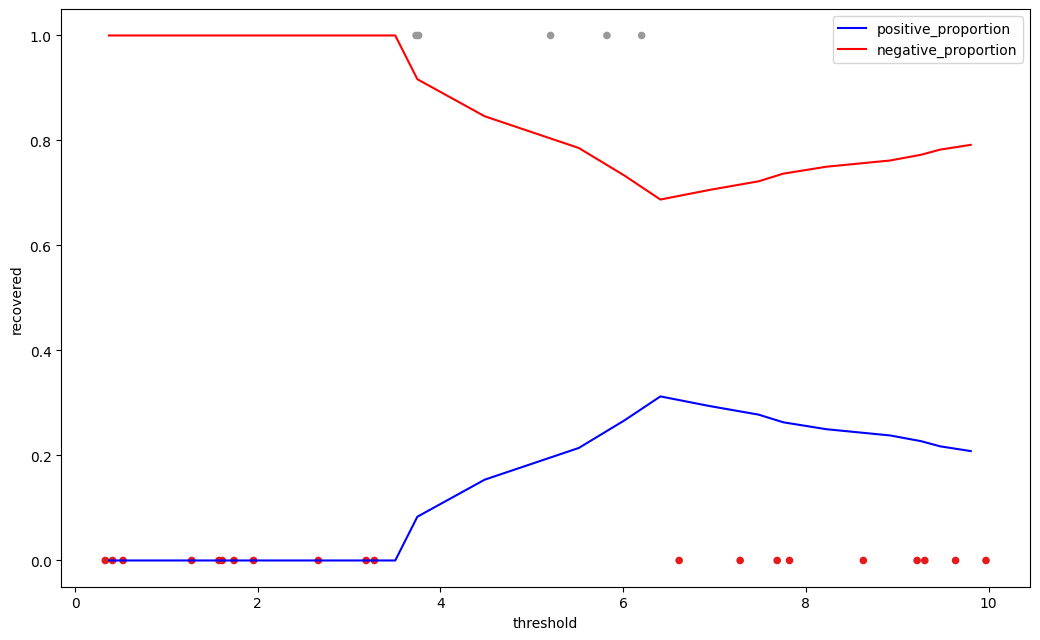

In [12]:
ax = patients_df.plot.scatter(x="dosage_mg", y="recovered", c="recovered", cmap="Set1", figsize=(12.5, 7.5), colorbar=False)
proportions_df.plot.line(x="threshold", y="positive_proportion", c="blue", ax=ax)
proportions_df.plot.line(x="threshold", y="negative_proportion", c="red", ax=ax)

Nasz zbiór zawiera dwie klasy, a my chcemy znaleźć taki podział, który pozwoli nam rozpoznawać obie. Szukamy zatem balansu, a do tego obliczenie proporcji